# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Read-data" data-toc-modified-id="Read-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read data</a></div><div class="lev1 toc-item"><a href="#Optimize-hyperparameters-using-district-27" data-toc-modified-id="Optimize-hyperparameters-using-district-27-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimize hyperparameters using district 27</a></div><div class="lev1 toc-item"><a href="#Get-posterior-mean-$\hat\beta$" data-toc-modified-id="Get-posterior-mean-$\hat\beta$-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get posterior mean <span class="MathJax_Preview" style="color: inherit;"></span><span class="MathJax" id="MathJax-Element-4-Frame" tabindex="0" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mover><mi>&amp;#x03B2;</mi><mo stretchy=&quot;false&quot;>&amp;#x005E;</mo></mover></mrow></math>" role="presentation" style="position: relative;"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-16" role="math" style="width: 0.643em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.514em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.188em 1000.51em 2.502em -999.998em); top: -2.21em; left: 0.002em;"><span class="mrow" id="MathJax-Span-17"><span class="texatom" id="MathJax-Span-18"><span class="mrow" id="MathJax-Span-19"><span class="munderover" id="MathJax-Span-20"><span style="display: inline-block; position: relative; width: 0.514em; height: 0px;"><span style="position: absolute; clip: rect(3.239em 1000.51em 4.296em -999.998em); top: -4.005em; left: 0.002em;"><span class="mi" id="MathJax-Span-21" style="font-family: STIXMathJax_Main-italic;">β<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.002em;"></span></span><span style="display: inline-block; width: 0px; height: 4.008em;"></span></span><span style="position: absolute; top: -4.261em; left: 0.13em;"><span style="height: 0.002em; vertical-align: 0.002em; width: 0.386em; display: inline-block; overflow: hidden;"></span><span class="mo" id="MathJax-Span-22" style="font-family: STIXMathJax_Main;">̂&nbsp;<span style="height: 0.002em; vertical-align: 0.002em; margin-left: -0.255em;"></span></span><span style="display: inline-block; overflow: hidden; height: 1px; width: 0.002em;"></span><span style="display: inline-block; width: 0px; height: 4.008em;"></span></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.213em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.267em; border-left: 0px solid; width: 0px; height: 1.425em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mrow class="MJX-TeXAtom-ORD"><mover><mi>β</mi><mo stretchy="false">^</mo></mover></mrow></math></span></span><script type="math/tex" id="MathJax-Element-4">\hat\beta</script></a></div><div class="lev1 toc-item"><a href="#Fit-GPs-to-residuals" data-toc-modified-id="Fit-GPs-to-residuals-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fit GPs to residuals</a></div><div class="lev1 toc-item"><a href="#Pairwise-treatment-effect" data-toc-modified-id="Pairwise-treatment-effect-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Pairwise treatment effect</a></div>

In [1]:
using LaTeXStrings
using GaussianProcesses
using GaussianProcesses: grad_slice!, cov!, addcov!, KernelData
import GaussianProcesses: get_params, set_params!, num_params
import GaussianProcesses: distance, optimize!
import GaussianProcesses: Mean, Kernel, grad_stack!, grad_stack
import PDMats: AbstractPDMat, PDMat
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Read data

In [2]:
NYC_sales=readtable("NYC_data/processed/NYC_sales.csv", header=true)
# categorical variables
pool!(NYC_sales, [:BOROUGH,
    :BUILDING_CLASS_CATEGORY,
    :BUILDING_CLASS_AT_TIME_OF_SALE,
    :ZIP_CODE,
    :TAX_CLASS_AT_PRESENT,
    :TAX_CLASS_AT_TIME_OF_SALE,
    :NEIGHBORHOOD,
    ])
NYC_sales[:logSalePricePerSQFT] = log(NYC_sales[:SALE_PRICE]) .- log(NYC_sales[:GROSS_SQUARE_FEET])
believable = zeros(Bool, size(NYC_sales,1))
for i in 1:size(NYC_sales,1)
    if isna(NYC_sales[i,:SALE_PRICE])
        continue
    end
    if NYC_sales[i,:SchDistr]==0
        continue
    end
    if isna(NYC_sales[i,:BUILDING_CLASS_AT_TIME_OF_SALE])
        continue
    end
    if isna(NYC_sales[i,:TAX_CLASS_AT_TIME_OF_SALE])
        continue
    end
    if isna(NYC_sales[i,:GROSS_SQUARE_FEET])
        continue
    end
    if NYC_sales[i,:GROSS_SQUARE_FEET]<100.0
        continue
    end
    if NYC_sales[i,:logSalePricePerSQFT] < 3.0
        # that's too cheap
        continue
    end
    if NYC_sales[i,:logSalePricePerSQFT] > 8.0
        # that's too expensive
        continue
    end
    if isna(NYC_sales[i,:X_PRJ])
        continue
    end
    if isna(NYC_sales[i,:Y_PRJ])
        continue
    end
    believable[i] = true
end
NYC_sales[:logSalePricePerSQFT] = log(NYC_sales[:SALE_PRICE]) .- log(NYC_sales[:GROSS_SQUARE_FEET])
nobsv_ = sum(believable)
for_mm = copy(NYC_sales[believable,:])
# for_mm[:GROSS_SQUARE_FEET] =  for_mm[:GROSS_SQUARE_FEET] .- mean(for_mm[:GROSS_SQUARE_FEET])
# for_mm[:GROSS_SQUARE_FEET] = for_mm[:GROSS_SQUARE_FEET] ./ std(for_mm[:GROSS_SQUARE_FEET])
reordering = collect(1:nobsv_)
schdistrs = unique(for_mm[:,:SchDistr])
istart = 1
for name in schdistrs
    indices = find(for_mm[:SchDistr] .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
schdistr_indices = Dict{Int,Vector{Int}}()
for name in schdistrs
    indices = find(for_mm[:SchDistr] .== name)
    schdistr_indices[name] = indices
end
;
Y_dict=Dict{Int, Vector{Float64}}()
X_dict=Dict{Int, Array{Float64,2}}()
for name in schdistrs
    Y_dict[name] = for_mm[schdistr_indices[name], :logSalePricePerSQFT]
    X_dict[name] = for_mm[schdistr_indices[name],[:X_PRJ, :Y_PRJ]]
end
sentinels_json=GeoJSON.parsefile("NYC_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{Int,Int},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end

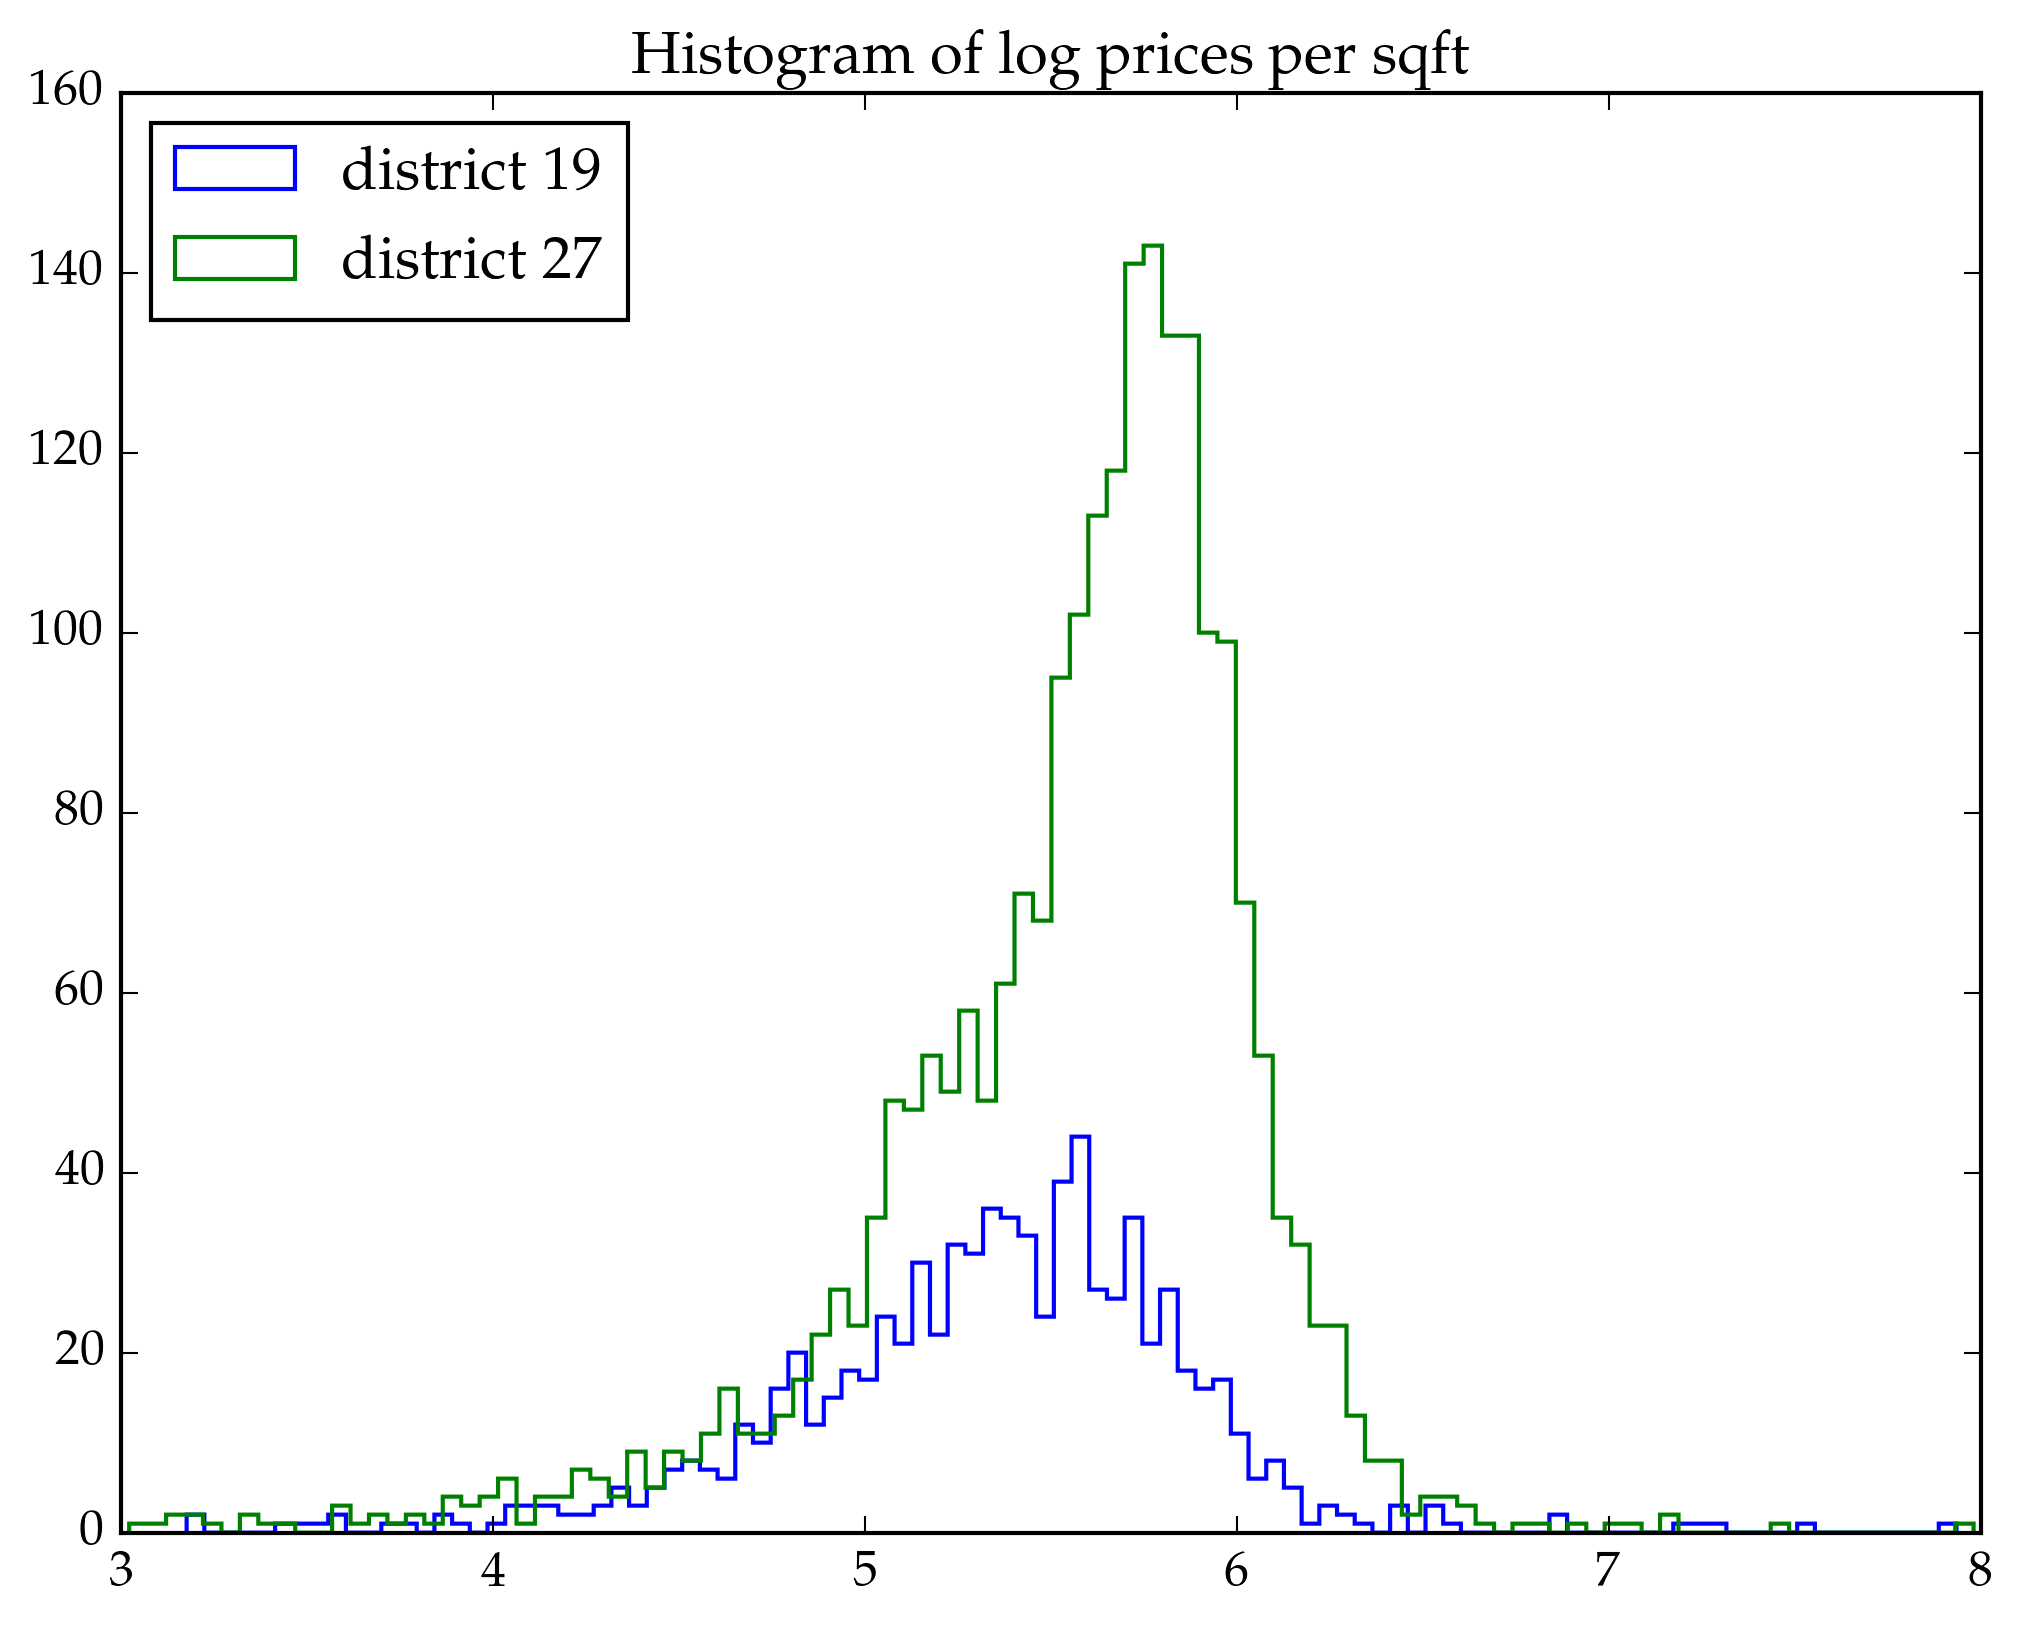

In [29]:
distrA = 19
distrB = 27
plt.plt[:hist](Y_dict[distrA],bins=100, histtype="step", label=@sprintf("district %d", distrA))
plt.plt[:hist](Y_dict[distrB],bins=100, histtype="step", label=@sprintf("district %d", distrB))
plt.title("Histogram of log prices per sqft")
plt.legend(loc="upper left")
;

In [4]:
contrasts_dict = Dict()
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePricePerSQFT ~ BUILDING_CLASS_AT_TIME_OF_SALE + TAX_CLASS_AT_TIME_OF_SALE, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;

In [5]:
σβ = 1.0
βkern_ = GaussianProcesses.LinIso(log(σβ))
type GPCovars   
    m:: Mean                # Mean object
    k::Kernel               # Kernel object
    βkern::Kernel
    logNoise::Float64       # log standard deviation of observation noise
    
    # Observation data
    nobsv::Int              # Number of observations
    X::Matrix{Float64}      # Input observations
    y::Vector{Float64}      # Output observations
    D::Array{Float64,2}
    data::KernelData        # Auxiliary observation data (to speed up calculations)
    βdata::KernelData
    p::Int                  # Dimensions of covariates
    dim::Int                # Dimension of inputs
    
    # Auxiliary data
    cK::AbstractPDMat       # (k + exp(2*obsNoise))
    alpha::Vector{Float64}  # (k + exp(2*obsNoise))⁻¹y
    mLL::Float64            # Marginal log-likelihood
    dmLL::Vector{Float64}   # Gradient marginal log-likelihood

    function GPCovars(X::Matrix{Float64}, 
        y::Vector{Float64}, 
        D::Matrix{Float64},
        m::Mean, 
        k::Kernel,
        βkern::Kernel,
        logNoise::Float64=-1e8,
        )
        dim, nobsv = size(X)
        p, nobsv2 = size(D)
        nobsv == nobsv2 || throw(ArgumentError("X and D should have the same number of rows"))
        length(y) == nobsv || throw(ArgumentError("X and y should have the same number of rows"))
        gp = new(m, k, βkern, logNoise, nobsv, X, y, D, KernelData(k, X), KernelData(βkern, D), p, dim)
        update_mll!(gp)
        return gp
    end
end

In [6]:
function update_mll!(gp::GPCovars, cK::Matrix{Float64})
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    gp.cK = PDMat(cK)
    gp.alpha = gp.cK \ (gp.y .- μ)
    gp.mLL = -dot((gp.y-μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0
end
function update_mll!(gp::GPCovars)
    Σbuffer = Array(Float64, gp.nobsv, gp.nobsv)
    update_mll!(gp, Σbuffer)
end
function update_mll!!(gp::GPCovars)
    cK = gp.cK.mat
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    chol_buffer = gp.cK.chol.factors
    copy!(chol_buffer, cK)
    chol = cholfact!(Symmetric(chol_buffer))
    gp.cK = PDMats.PDMat(cK, chol)
    gp.alpha = gp.cK \ (gp.y - μ)
    gp.mLL = -dot((gp.y - μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0 # Marginal log-likelihood
end
function get_ααinvcKI!(ααinvcKI::Matrix, cK::AbstractPDMat, α::Vector)
    nobsv = length(α)
    size(ααinvcKI) == (nobsv, nobsv) || throw(ArgumentError, 
                @sprintf("Buffer for ααinvcKI should be a %dx%d matrix, not %dx%d",
                         nobsv, nobsv,
                         size(ααinvcKI,1), size(ααinvcKI,2)))
    ααinvcKI[:,:] = 0.0
    @inbounds for i in 1:nobsv
        ααinvcKI[i,i] = -1.0
    end
    A_ldiv_B!(cK.chol, ααinvcKI)
    LinAlg.BLAS.ger!(1.0, α, α, ααinvcKI)
end
""" Update gradient of marginal log-likelihood """
function update_mll_and_dmll!(gp::GPCovars,
    Kgrad::Matrix{Float64},
    ααinvcKI::Matrix{Float64}
    ; 
    noise::Bool=true, # include gradient component for the logNoise term
    mean::Bool=true, # include gradient components for the mean parameters
    kern::Bool=true, # include gradient components for the spatial kernel parameters
    beta::Bool=true, # include gradient components for the linear regression prior terms
    )
    update_mll!!(gp)
    n_mean_params = num_params(gp.m)
    n_kern_params = num_params(gp.k)
    n_beta_params = num_params(gp.βkern)
    gp.dmLL = Array(Float64, noise + mean*n_mean_params + kern*n_kern_params + beta*n_beta_params)
    logNoise = gp.logNoise
    get_ααinvcKI!(ααinvcKI, gp.cK, gp.alpha)
    i=1
    if noise
        gp.dmLL[i] = exp(2.0*logNoise)*trace(ααinvcKI)
        i+=1
    end
    if mean
        Mgrads = grad_stack(gp.m, gp.X)
        for j in 1:n_mean_params
            gp.dmLL[i] = dot(Mgrads[:,j],gp.alpha)
            i += 1
        end
    end
    if kern
        for iparam in 1:n_kern_params
            grad_slice!(Kgrad, gp.k, gp.X, gp.data, iparam)
            gp.dmLL[i] = dot(Kgrad,ααinvcKI)/2.0
            i+=1
        end
    end
    if beta
        for iparam in 1:n_beta_params
            grad_slice!(Kgrad, gp.βkern, gp.D, gp.βdata, iparam)
            gp.dmLL[i] = vecdot(ααinvcKI,Kgrad)/2.0
            i+=1
        end
    end
end
function set_params!(gp::GPCovars, hyp::Vector{Float64}; 
                    noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    i=1
    if noise
        gp.logNoise = hyp[i]
        i+=1
    end
    if mean
        set_params!(gp.m, hyp[i:i+num_params(gp.m)-1])
        i+=num_params(gp.m)
    end
    if kern
        set_params!(gp.k, hyp[i:i+num_params(gp.k)-1])
        i+=num_params(gp.k)
    end
    if beta
        set_params!(gp.βkern, hyp[i:i+num_params(gp.βkern)-1])
        i+=num_params(gp.βkern)
    end
end
function get_params(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    params = Float64[]
    if noise; push!(params, gp.logNoise); end
    if mean;  append!(params, get_params(gp.m)); end
    if kern; append!(params,  get_params(gp.k)); end
    if beta; append!(params,  get_params(gp.βkern)); end
    return params
end
function optimize!(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true, 
                    method=ConjugateGradient(), kwargs...)
    Kgrad_buffer = Array(Float64, gp.nobsv, gp.nobsv)
    ααinvcKI = Array(Float64, gp.nobsv, gp.nobsv)
    function mll(hyp::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll!!(gp)
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end        
    end

    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll_and_dmll!(gp, Kgrad_buffer, ααinvcKI; noise=noise, mean=mean, kern=kern, beta=beta)
            grad[:] = -gp.dmLL
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end 
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = get_params(gp;  noise=noise, mean=mean, kern=kern, beta=beta)  # Initial hyperparameter values
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    set_params!(gp, results.minimum; noise=noise, mean=mean, kern=kern, beta=beta)
    return results
end

optimize! (generic function with 2 methods)

# Optimize hyperparameters using district 27

In [7]:
district=27 # bigger district of the two
# GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.2
L = 1300.0
_kern = SEIso(log(L), log(σf))
_logNoise = log(σy)
_X = X_dict[district]'
_Y = Y_dict[district]
_Dd = D_[schdistr_indices[district],:]'
_m = MeanConst(mean(_Y))
@time gp=GPCovars(_X, _Y, _Dd, _m, _kern, βkern_, _logNoise)
;

  1.343015 seconds (795.13 k allocations: 185.197 MB, 11.73% gc time)


In [8]:
@time opt_out=optimize!(gp, iterations=10, x_tol=1e-4, f_tol=1e-3);

New linesearch
bracketing: ia = 1, ib = 2, c = 0.020000000000000004, phic = 311521.79900654417, dphic = 1.5653736605520714e7
linesearch: ia = 1, ib = 2, a = 0.0, b = 0.020000000000000004, phi(a) = 3413.75721998399, phi(b) = 311521.79900654417
secant2: a = 0.0, b = 0.020000000000000004, c = 0.015122484887254333
update: ia = 1, a = 0.0, ib = 2, b = 0.020000000000000004, c = 0.015122484887254333, phic = 235170.46214218056, dphic = 1.5653736605521154e7
secant2: iA = 1, iB = 3, ic = 3
secant2 output: a = 0.0, b = 0.015122484887254333
Linesearch: secant failed, using bisection
update: ia = 1, a = 0.0, ib = 3, b = 0.015122484887254333, c = 0.007561242443627166, phic = 116808.76451914628, dphic = 1.565373660552098e7
linesearch: ia = 1, ib = 4, a = 0.0, b = 0.007561242443627166, phi(a) = 3413.75721998399, phi(b) = 116808.76451914628
secant2: a = 0.0, b = 0.007561242443627166, c = 0.005717238729130868
update: ia = 1, a = 0.0, ib = 4, b = 0.007561242443627166, c = 0.005717238729130868, phic = 879

In [9]:
opt_out

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.6094379124341003,5.560919115673984, ...]
 * Minimizer: [-0.8487823947828668,5.560857066321416, ...]
 * Minimum: 1.379086e+03
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 1.0e-04: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-03: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 32
 * Gradient Calls: 25

In [10]:
print(opt_out.minimum)

[-0.848782,5.56086,8.13893,-1.76246,0.83009]

In [11]:
@printf("σ_y: %.4f\n", exp(gp.logNoise))
@printf("σ_f: %.4f\n", √(gp.k.σ2))
@printf("σ_β: %.4f\n", 1/√gp.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(gp.k.ℓ2))

σ_y: 0.4279
σ_f: 0.1716
σ_β: 0.4360
ℓ: 3425.2547


# Get posterior mean $\hat\beta$

In [12]:
function get_ΣYβ!(gp::GPCovars)
    Σ = cov(gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        Σ[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    return PDMats.PDMat(Σ)
end

get_ΣYβ! (generic function with 1 method)

In [13]:
@time ΣY_β = get_ΣYβ!(gp);

  0.468783 seconds (472.70 k allocations: 96.085 MB, 2.25% gc time)


In [14]:
tmp = PDMats.X_invA_Xt(ΣY_β, gp.D)
for i in 1:p
    tmp[i,i] += gp.βkern.ℓ2
end
m = mean(gp.m,gp.X)
βhat = (tmp \ gp.D) * (ΣY_β \ (gp.y.-m))
βhat_dict=Dict(zip(coefnames(mf), βhat))

Dict{String,Float64} with 131 entries:
  "BUILDING_CLASS_AT_TIME_OF_SALE: V0" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: E9" => -0.455235
  "BUILDING_CLASS_AT_TIME_OF_SALE: K2" => -0.37933
  "BUILDING_CLASS_AT_TIME_OF_SALE: F8" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: F9" => -0.80282
  "BUILDING_CLASS_AT_TIME_OF_SALE: A4" => -0.123678
  "BUILDING_CLASS_AT_TIME_OF_SALE: S3" => 0.0715673
  "BUILDING_CLASS_AT_TIME_OF_SALE: O5" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: W8" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: B9" => -0.0648742
  "BUILDING_CLASS_AT_TIME_OF_SALE: C4" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: O6" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: A7" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: GU" => 0.113622
  "BUILDING_CLASS_AT_TIME_OF_SALE: H8" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: I6" => 0.0
  "BUILDING_CLASS_AT_TIME_OF_SALE: C3" => -0.230402
  "BUILDING_CLASS_AT_TIME_OF_SALE: C2" => -0.177762
  "BUILDING_CLASS_AT_TIME_OF_SALE: D1" => 0.105638
  "BUILDING_CLASS_AT_TIME_OF_S

# Fit GPs to residuals

In [15]:
resid = for_mm[:logSalePricePerSQFT] - D_*βhat
resid_dict=Dict{Int, Vector{Float64}}()
for name in schdistrs
    resid_dict[name] = resid[schdistr_indices[name]]
end

In [16]:
resid_GP_dict=Dict{Int, GP}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), gp.k, gp.logNoise)
    resid_GP_dict[name] = fit
end

In [30]:
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
n◫ = size(X◫, 2)
resid_pred_A = GaussianProcesses.predict(resid_GP_dict[distrA], X◫; full_cov=true)
resid_pred_B = GaussianProcesses.predict(resid_GP_dict[distrB], X◫; full_cov=true)
resid_μposterior = resid_pred_A[1].-resid_pred_B[1]
resid_Σposterior = resid_pred_A[2]+resid_pred_B[2]
;

In [32]:
distrA,distrB

(19,27)

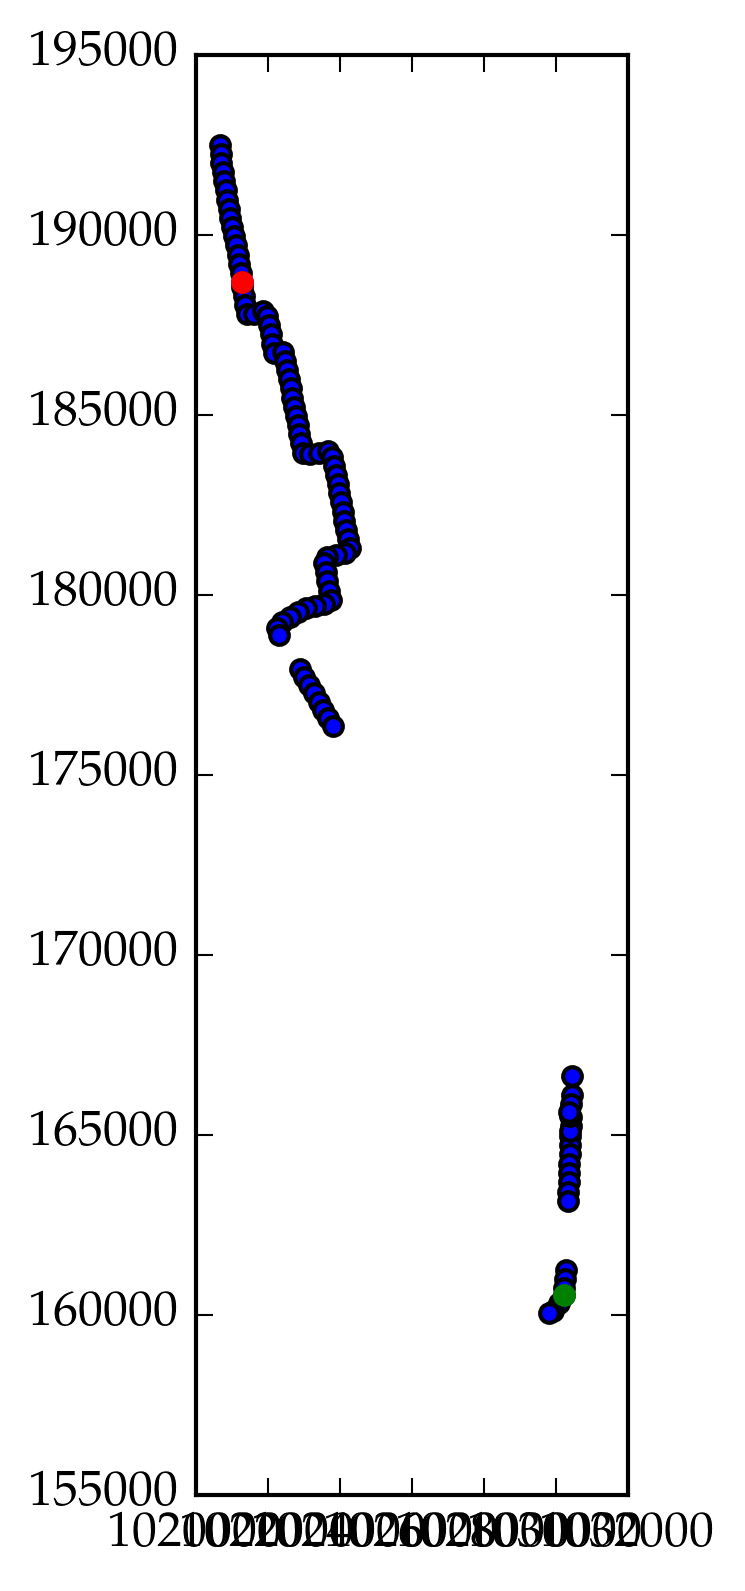

In [33]:
plt.scatter(X◫[1,:], X◫[2,:])
plt.scatter(X◫[1,1], X◫[2,1], color="green", s=20)
plt.scatter(X◫[1,end], X◫[2,end], color="red", s=20)
plt.gca()[:set_aspect]("equal")

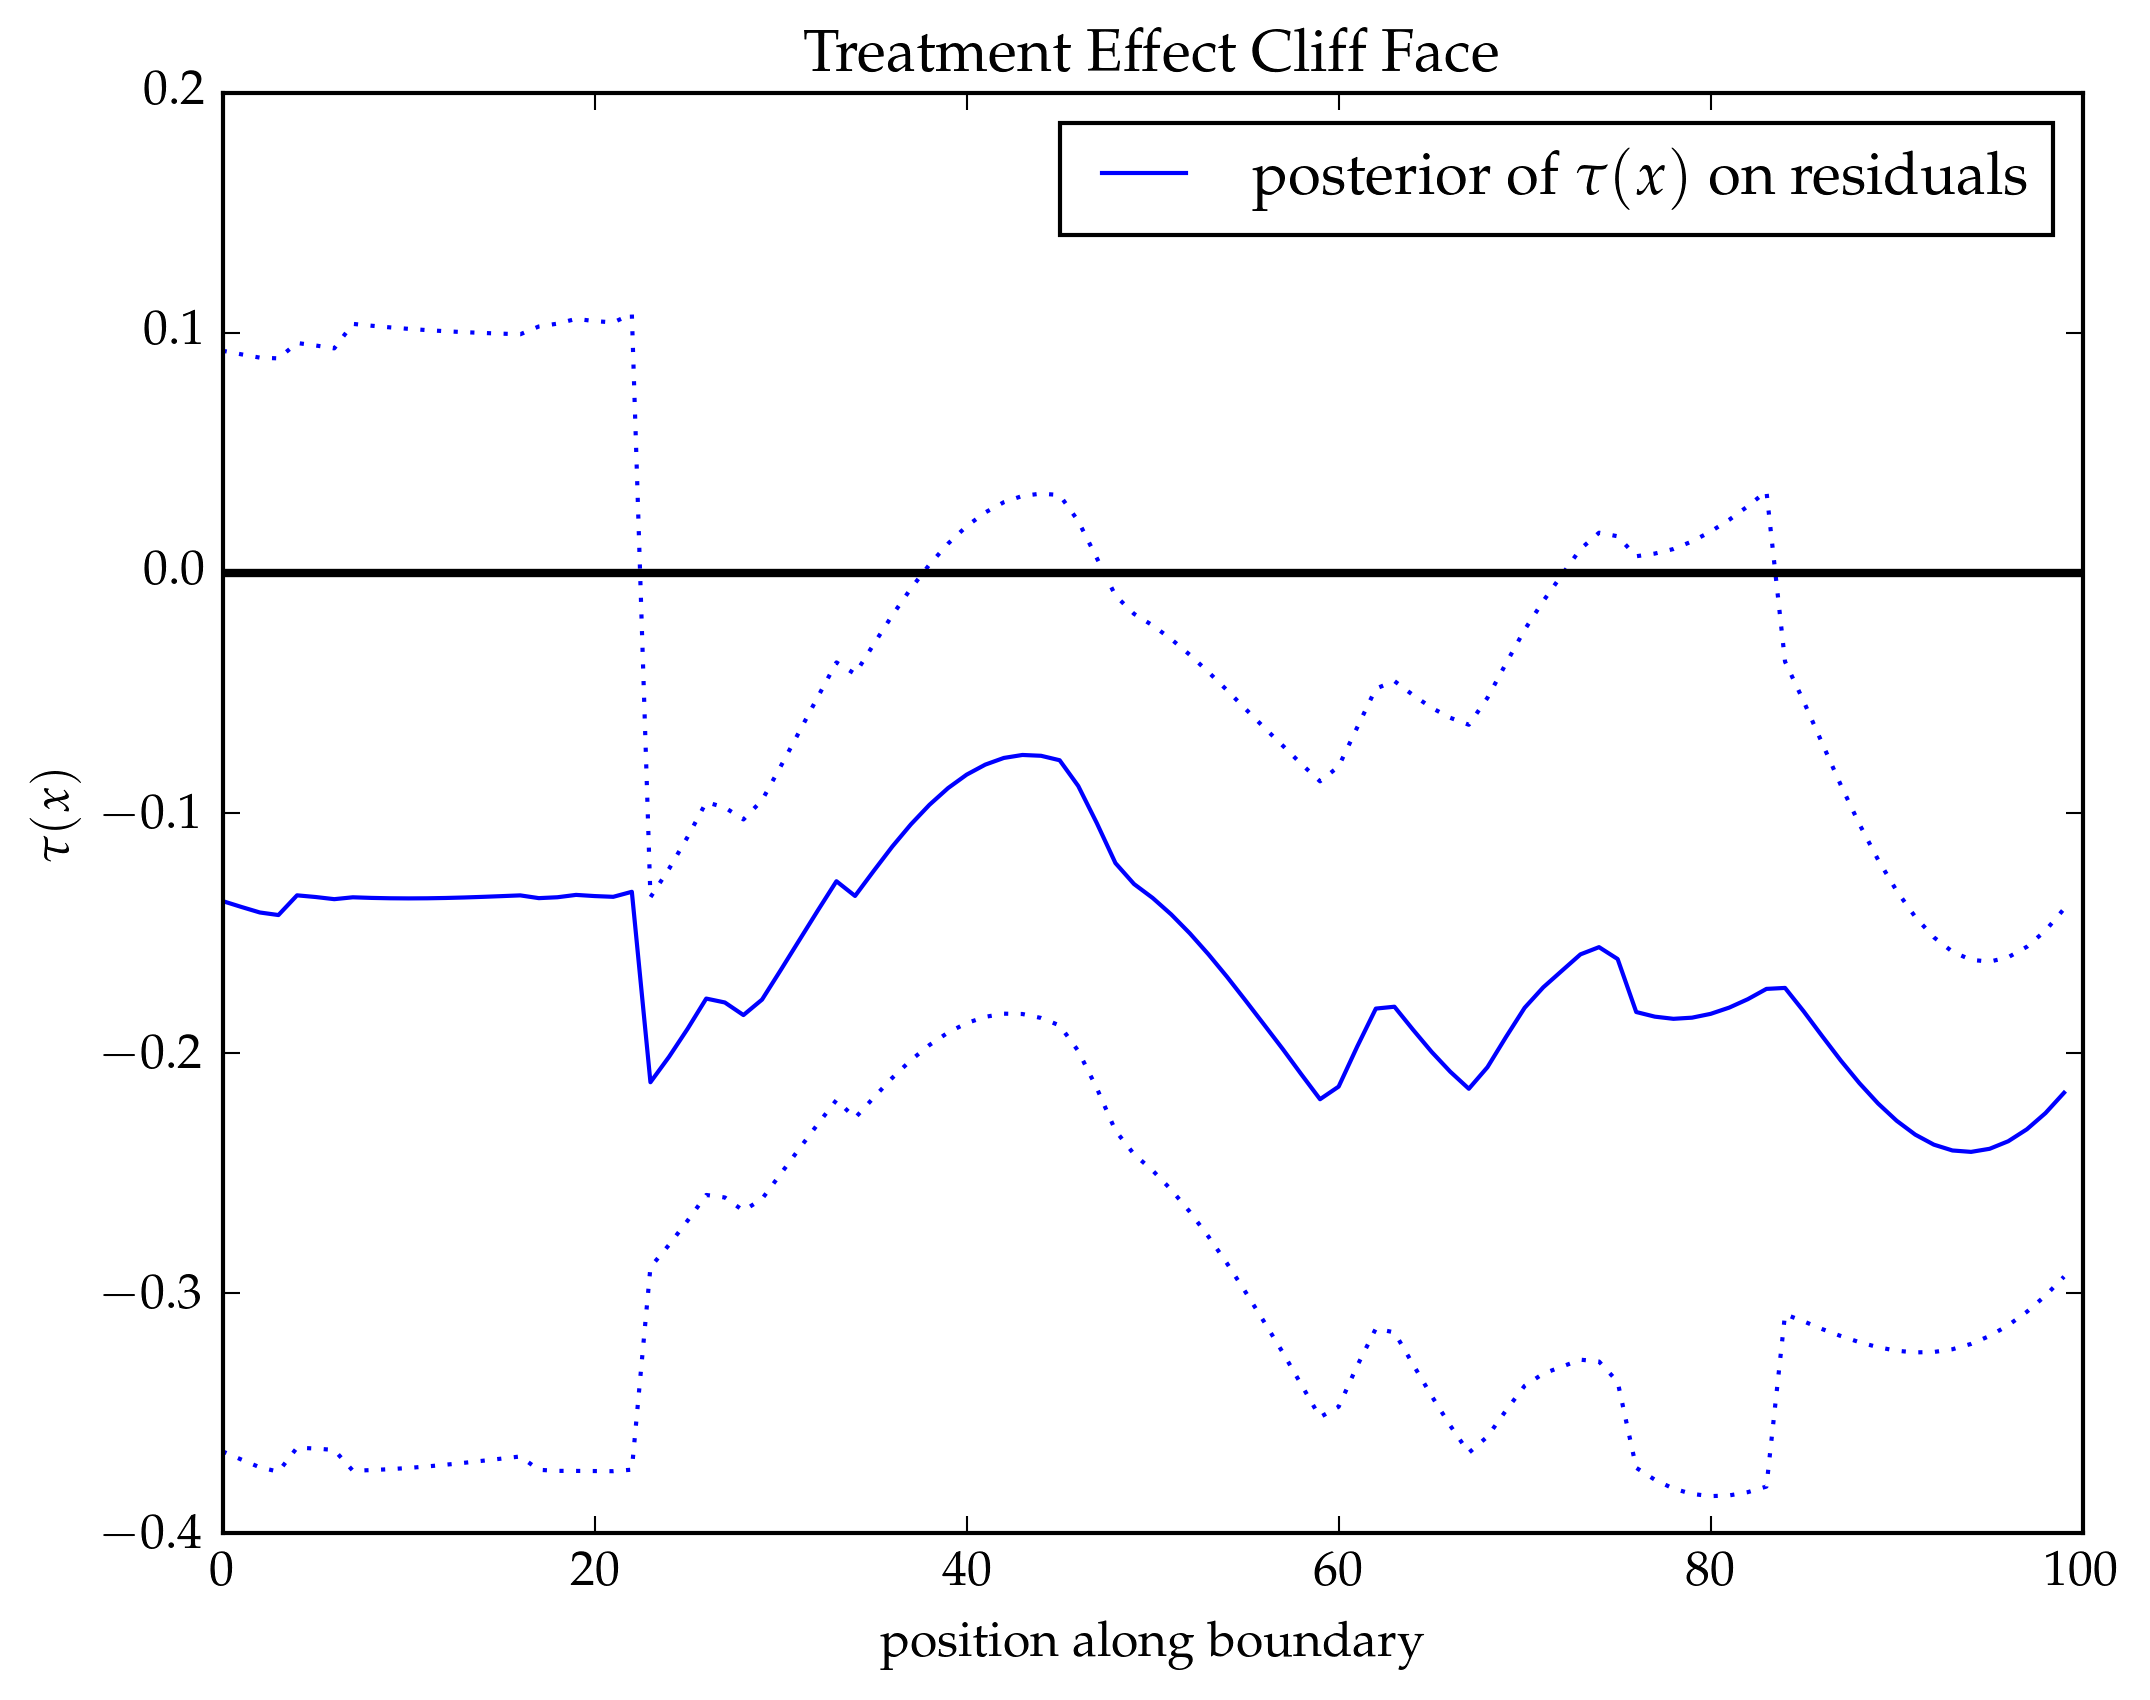

In [18]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-√diag(resid_Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

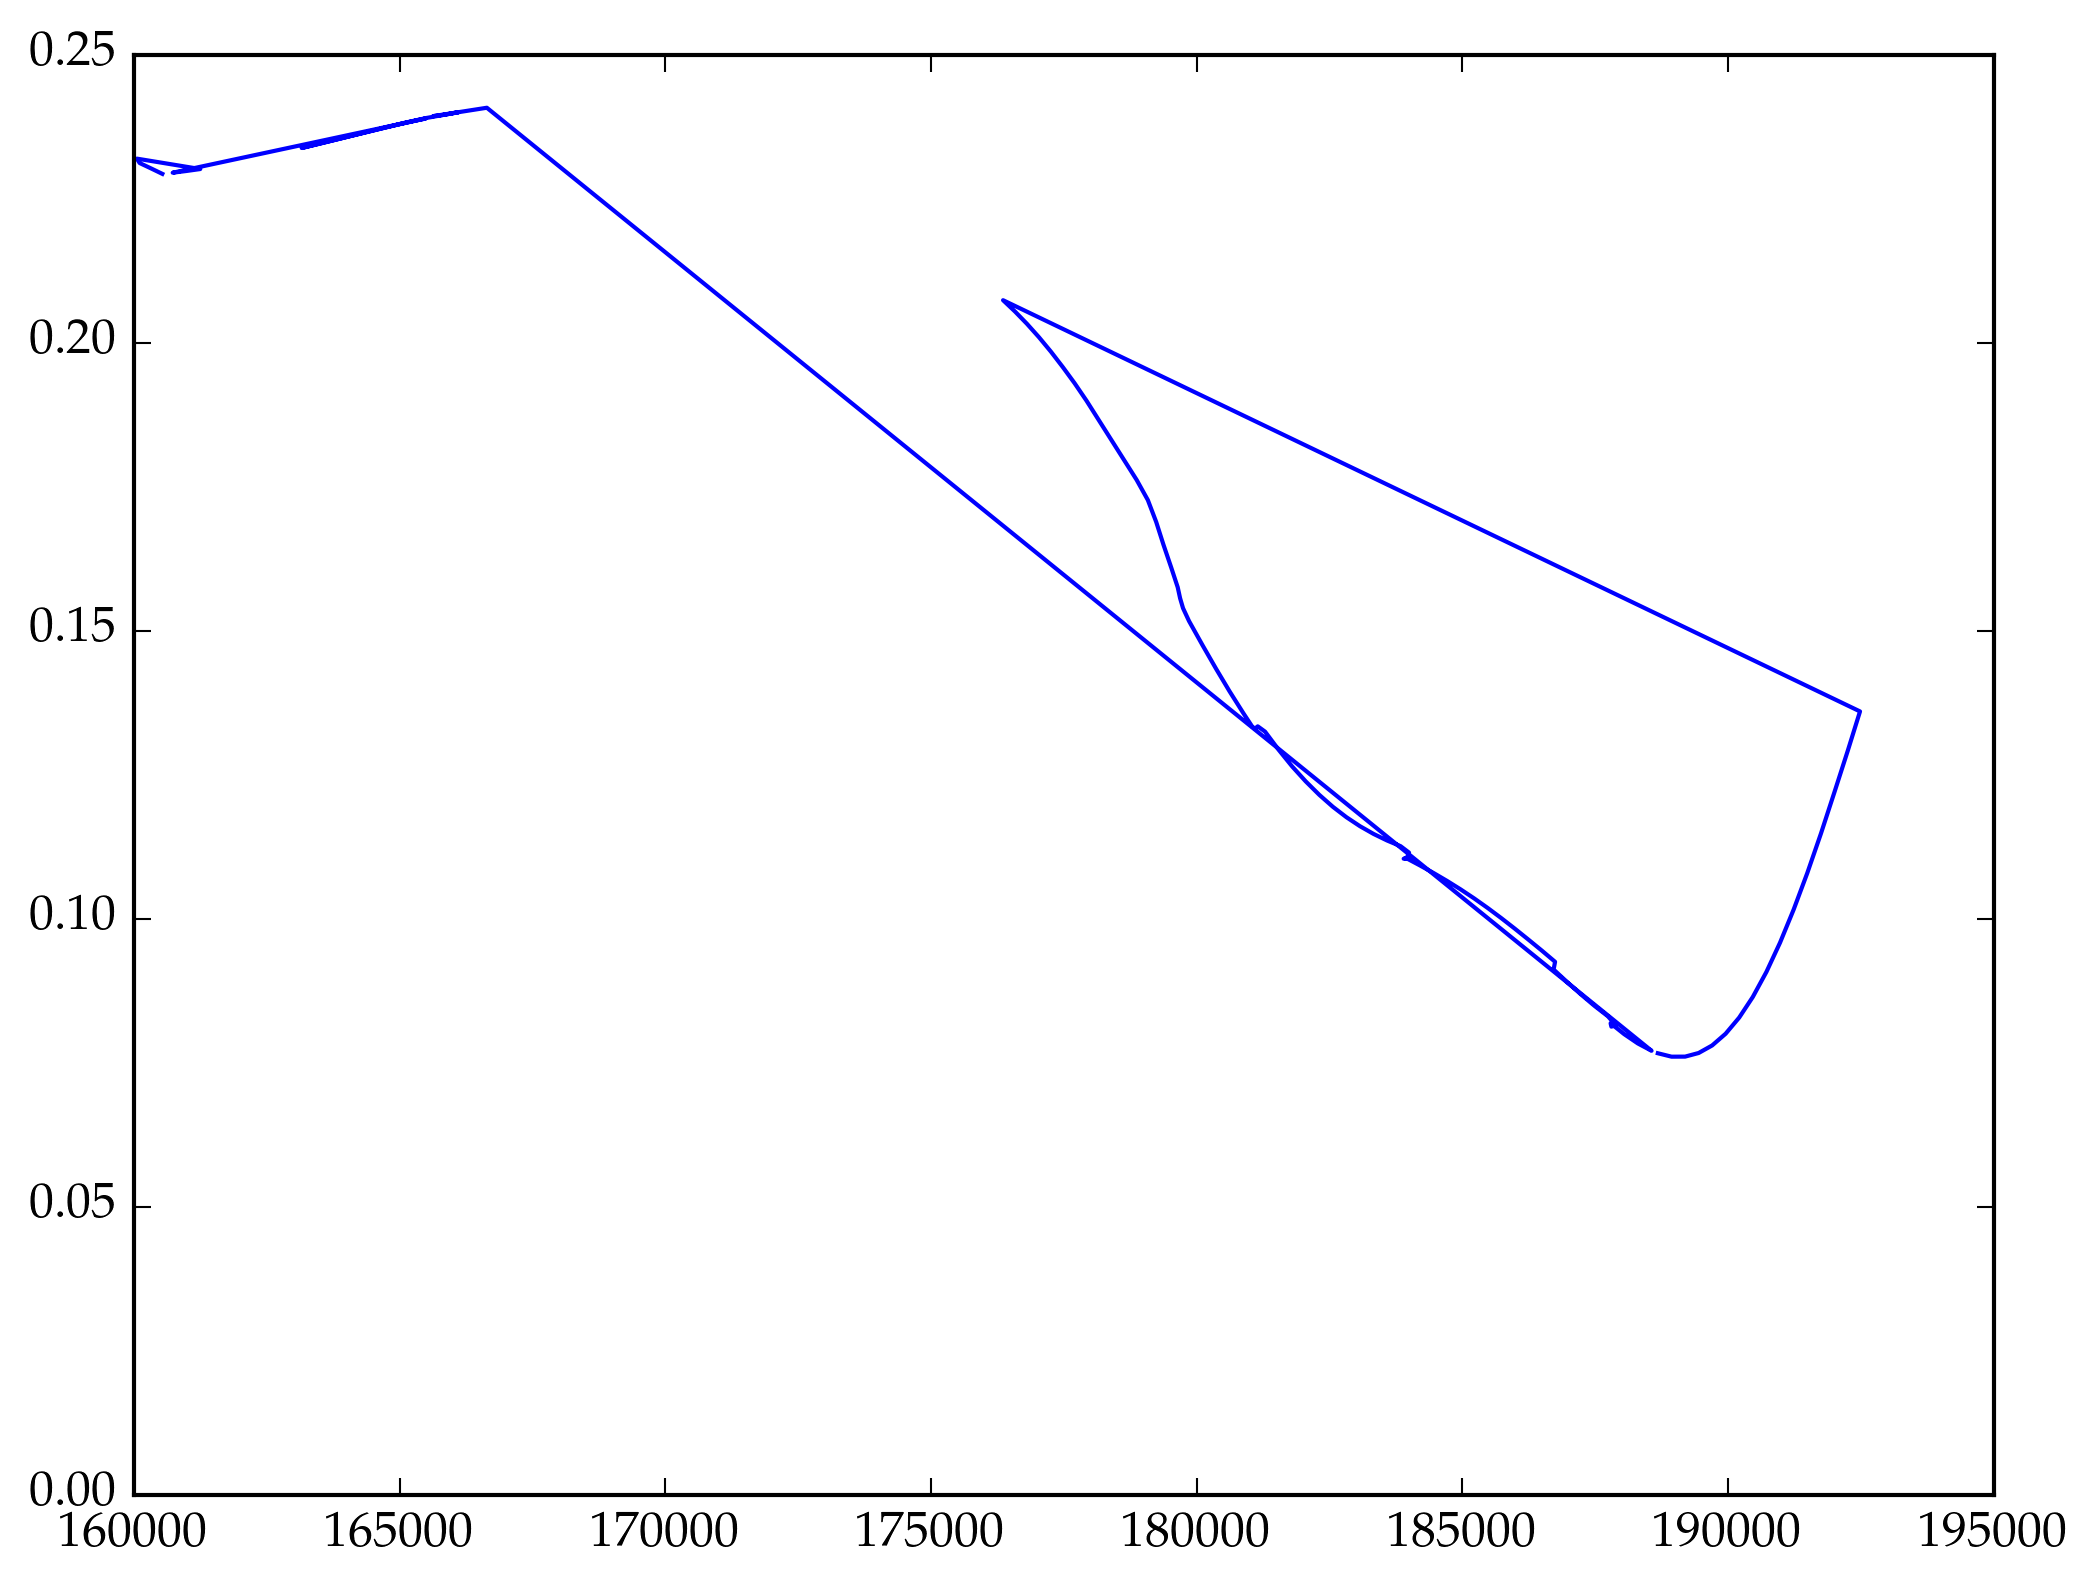

(0,0.25)

In [19]:
plt.plot(X◫[2,:], √diag(resid_Σposterior))
plt.ylim(0)

In [20]:
n◫ = size(X◫)[2]
denom_weighted = dot(ones(n◫),(resid_Σposterior \ ones(n◫)))
τhat_weighted = sum(resid_Σposterior\resid_μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
τpost=Normal(τhat_weighted, √Vτhat_weighted)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost), std(τpost))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost, 0.0)*100)

τ|Y ∼ Normal(μ=-0.174, σ=0.049)
P(τ>0|Y) = 0.022%

In [21]:
mean(Y_dict[distrA])-mean(Y_dict[distrB])

-0.2244708363037784

# Pairwise treatment effect

Check for a treatment effect between every pair of districts.

In [22]:
function get_τpost(gp_i::GP, gp_j::GP, sentinelX::Matrix)
    n◫ = size(sentinelX, 2)
    resid_pred_A = GaussianProcesses.predict(gp_i, sentinelX; full_cov=true)
    resid_pred_B = GaussianProcesses.predict(gp_j, sentinelX; full_cov=true)
    resid_μposterior = resid_pred_A[1].-resid_pred_B[1]
    resid_Σposterior = resid_pred_A[2]+resid_pred_B[2]
    
    denom_weighted = dot(ones(n◫),(resid_Σposterior \ ones(n◫)))
    τhat_weighted = sum(resid_Σposterior\resid_μposterior) / denom_weighted
    Vτhat_weighted = 1.0/denom_weighted
    τpost=Normal(τhat_weighted, √Vτhat_weighted)
    return τpost
end 

get_τpost (generic function with 1 method)

In [23]:
get_τpost(resid_GP_dict[distrA], resid_GP_dict[distrB], hcat(sentinels[distrA,distrB].coordinates...))

Distributions.Normal{Float64}(μ=-0.17378699417184848, σ=0.04945303775096739)

In [24]:
typeof(sentinels)

Dict{Tuple{Int64,Int64},GeoJSON.MultiPoint}

In [25]:
τpost_pairs = Dict{Tuple{Int64,Int64},Normal}()
for (distrA,distrB) in keys(sentinels)
    X◫ = hcat(sentinels[distrA,distrB].coordinates...)
    τpost = get_τpost(resid_GP_dict[distrA], resid_GP_dict[distrB], X◫)
    τpost_pairs[distrA,distrB] = τpost
end

In [26]:
length(τpost_pairs)

117

In [27]:
mean(X_dict[3],1)

1×2 Array{Float64,2}:
 9.92929e5  2.27151e5

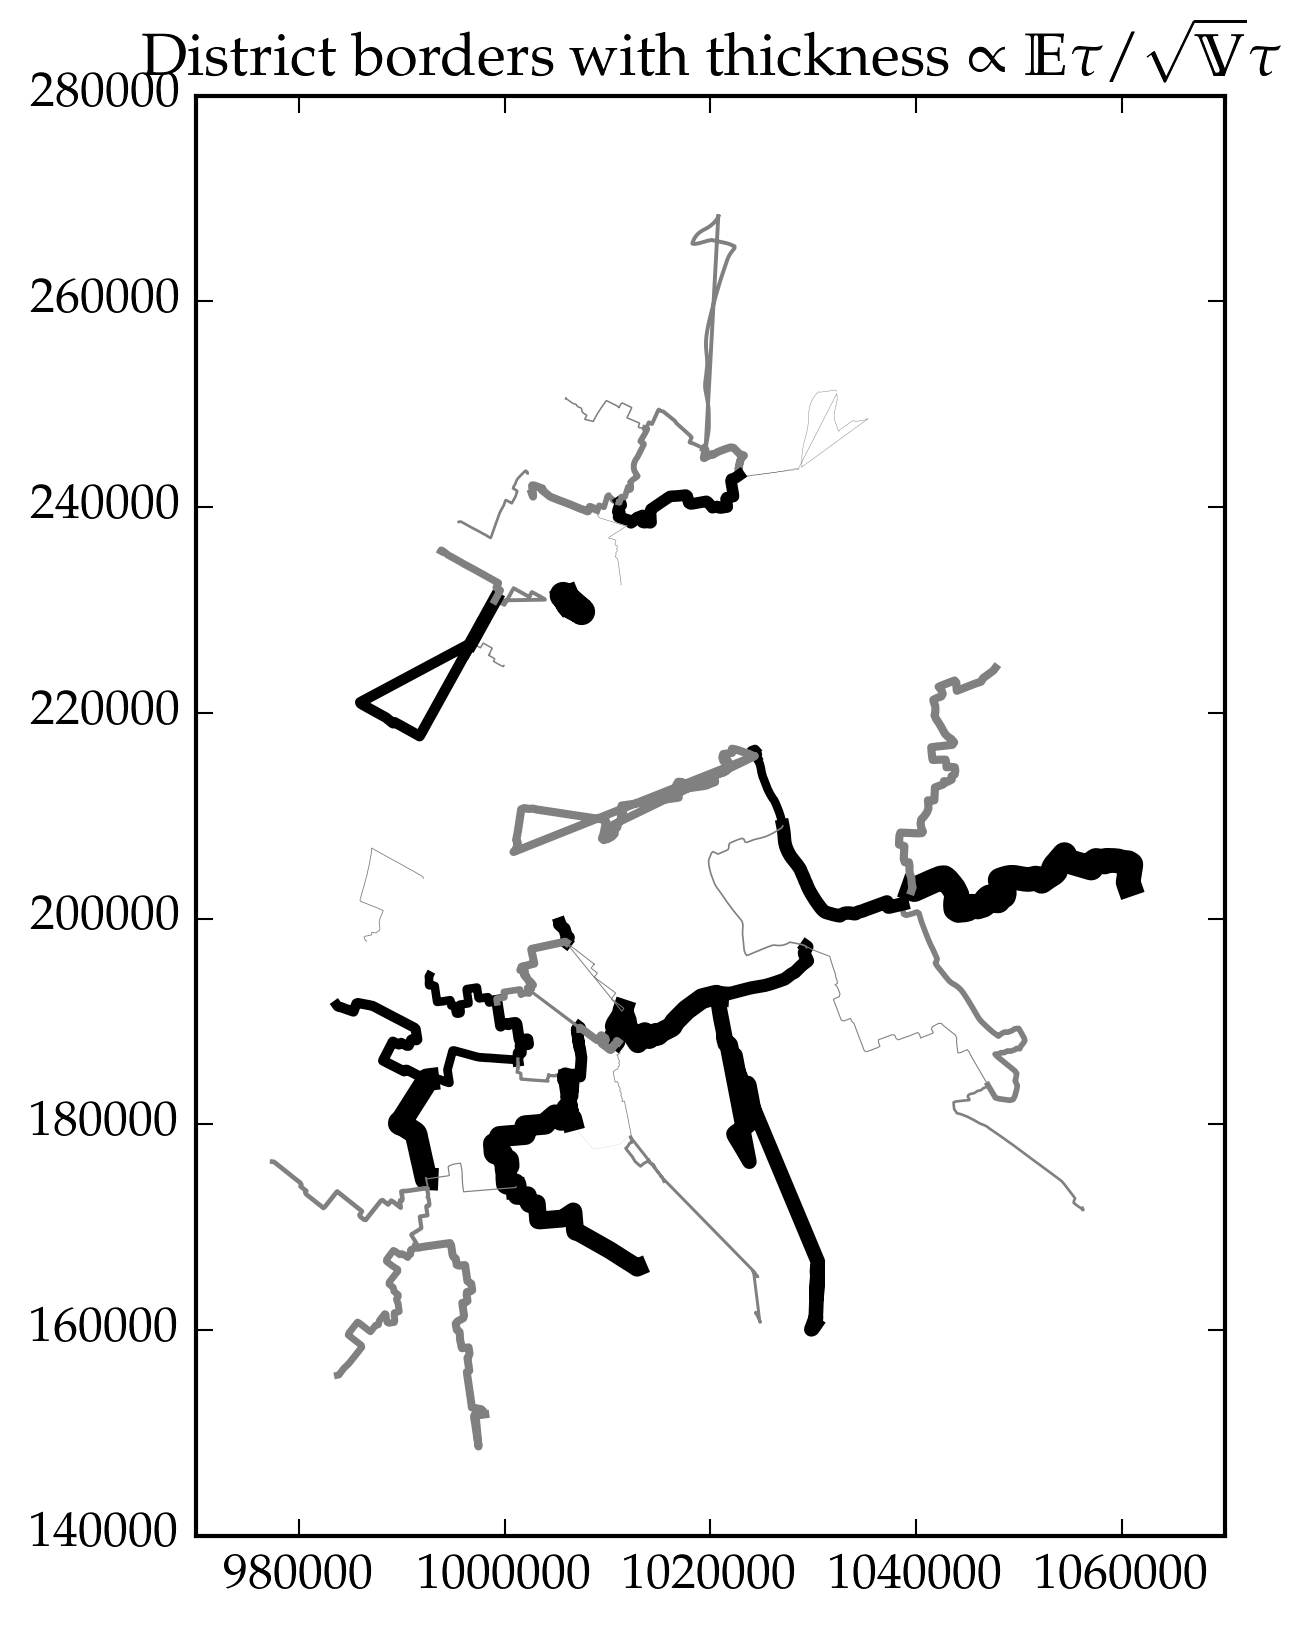

PyObject <matplotlib.text.Text object at 0x31fab77d0>

  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  li

In [28]:
for distr_pair in keys(sentinels)
    distrA, distrB = distr_pair
    if distrA > distrB
        continue
    end
    X◫ = hcat(sentinels[distr_pair].coordinates...)
    
    center_A = mean(X_dict[distrA],1)
    center_A = mean(X_dict[distrB],1)
    center_X◫ = mean(X◫, 1)
    arrow_A = 
    X_towards_A = 
    
    τpost = τpost_pairs[distr_pair]
    eff_size = abs(mean(τpost)) / std(τpost)
    if eff_size > 2
        color="black"
    else
        color="gray"
    end
    plt.plot(X◫[1,:], X◫[2,:], linewidth=eff_size, color=color)
end
plt.gca()[:set_aspect]("equal")
plt.title(L"District borders with thickness $\propto \mathbb{E}\tau/{\sqrt\mathbb{V}\tau}$ ")